## 전국과 서울의 확진자 데이터 비교


In [ ]:
#데이터 전처리 함수
def covid_preprocessing_seoul(df):
  df.columns=['날짜', '확진자수']
  df['날짜'] = pd.to_datetime(df['날짜'])
  df['확진자수_전일'] = [0] + df['확진자수'].iloc[:-1].tolist()
  df['확진자수_신규'] = df['확진자수'] - df['확진자수_전일']

  pre_weeks_df = pd.DataFrame(pd.date_range(pd.to_datetime('2020-01-01'), pd.to_datetime('2020-01-19')),
                              columns=['날짜'])
  df = pd.merge(pre_weeks_df, df, 'outer', '날짜').fillna(0)

  df['월'] = df['날짜'].dt.month
  df['주차'] = df['날짜'].dt.weekofyear
  df = df.drop(['확진자수_전일'], axis=1)
  return df

covid_seoul = time_province[['date', 'province', 'confirmed']]
covid_seoul=covid_seoul[covid_seoul.province=="서울"].drop(columns="province")
covid_seoul=covid_preprocessing_seoul(covid_seoul)


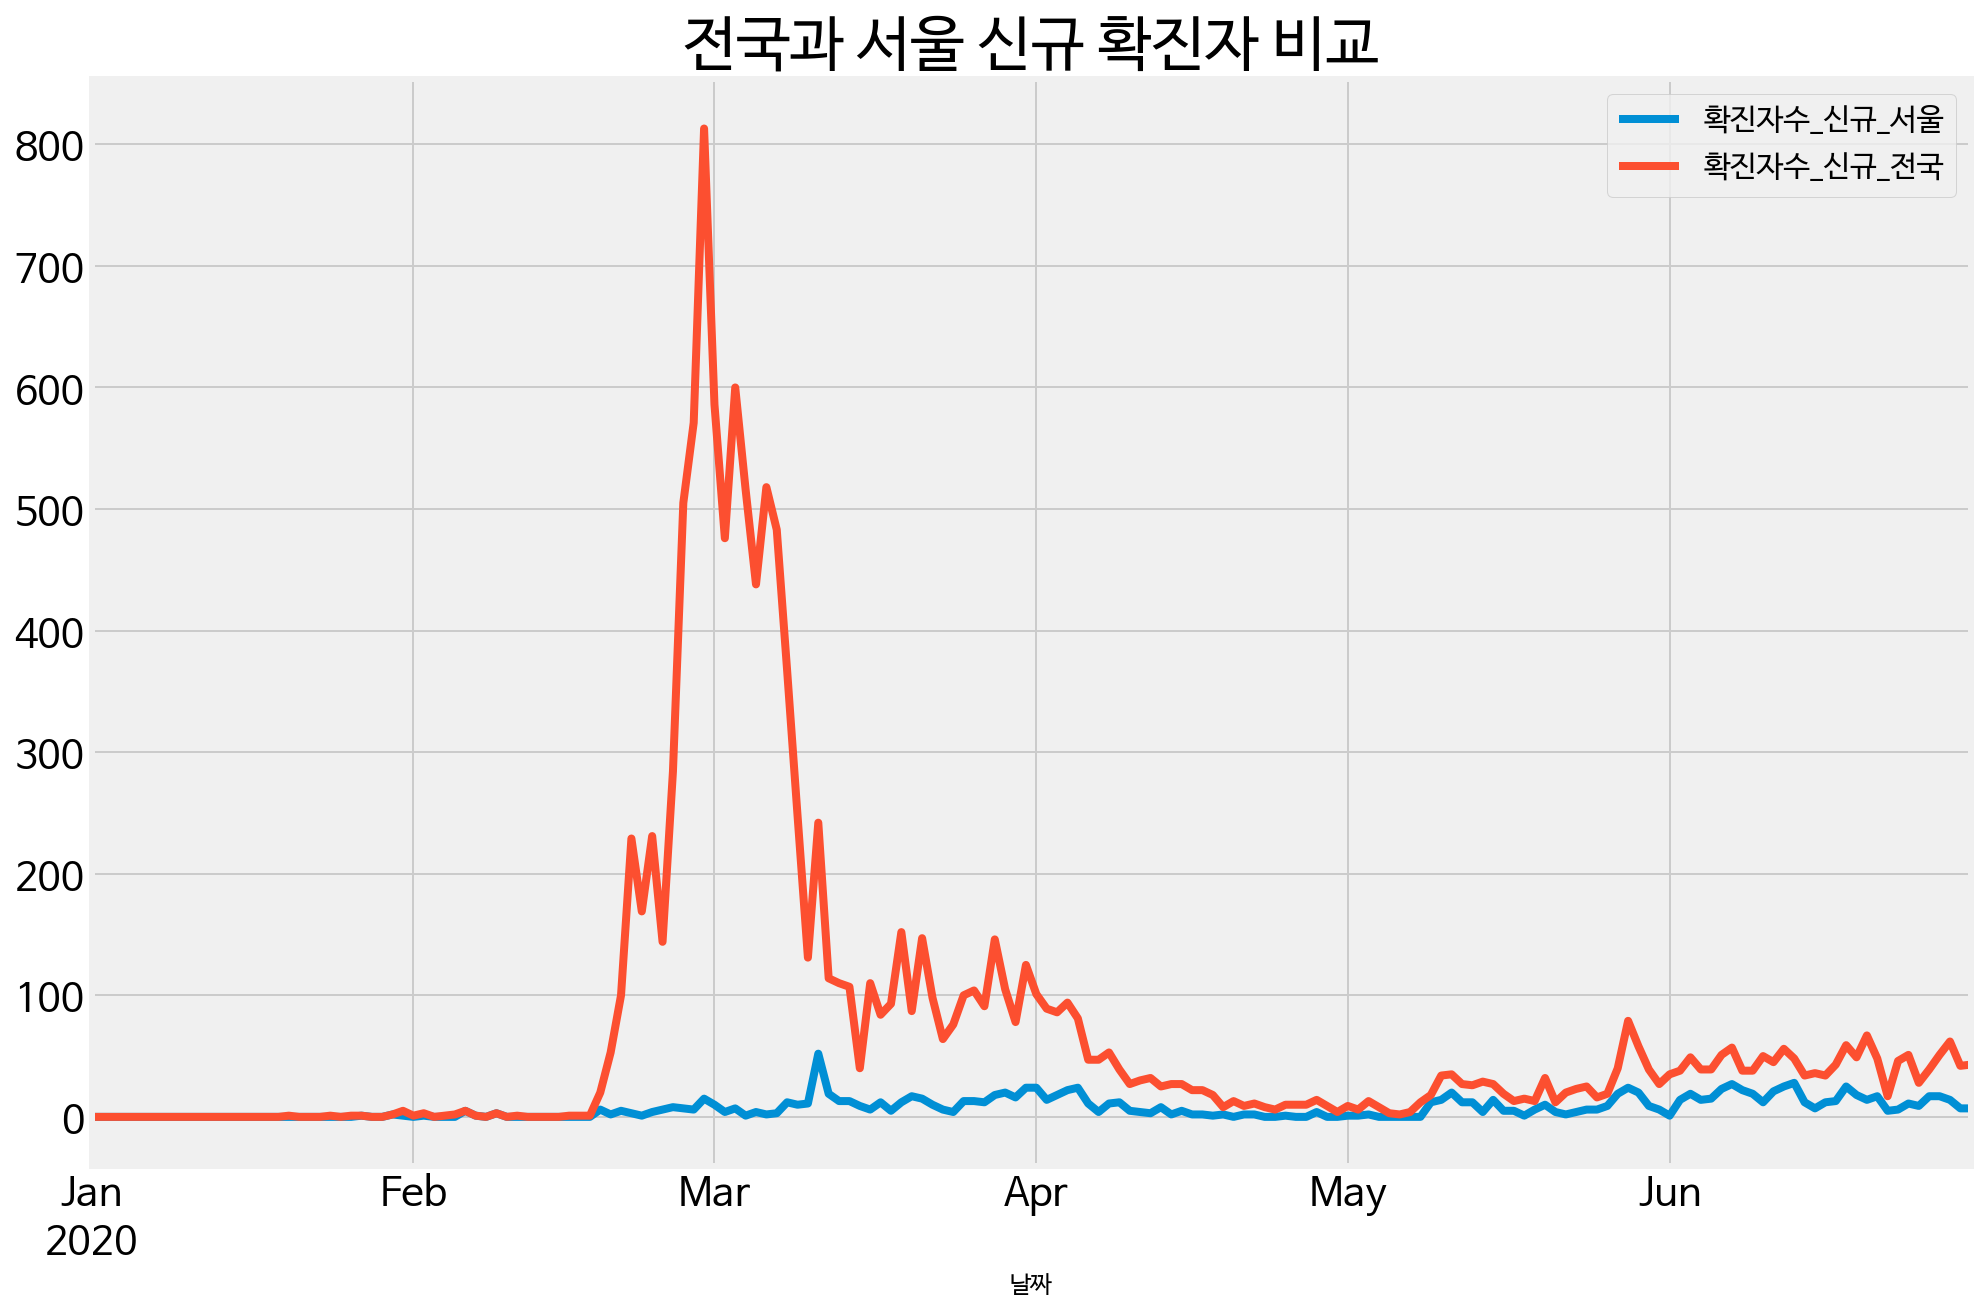

In [ ]:
#서울 전국 신규 확진자 데이터
covid_time_processed_for_merging=covid_time_processed.drop(columns=["검사자수","검사자수_신규"])
covid_df_comparison= pd.merge(covid_time_processed_for_merging.loc[:,:"확진자수_신규"], covid_seoul, on='날짜', suffixes=('_전국', '_서울'))
covid_df_compare=covid_df_comparison.groupby("날짜")[["확진자수_신규_서울","확진자수_신규_전국"]].sum()
covid_df_compare.plot(kind="line", figsize=(15,10))
plt.title("전국과 서울 신규 확진자 비교", fontsize=30)
plt.legend(fontsize=15)

In [ ]:
#서울 전국 비교 정리
covid_df_compare_percent=covid_df_compare
covid_df_compare_percent["서울_비중(%)"]=(covid_df_compare["확진자수_신규_서울"]/covid_df_compare["확진자수_신규_전국"]*100).round(2)
covid_df_compare_percent.fillna(0)

,확진자수_신규_서울,확진자수_신규_전국,서울_비중(%)
날짜,,,
2020-01-01,0.0,0.0,0.00
2020-01-02,0.0,0.0,0.00
2020-01-03,0.0,0.0,0.00
2020-01-04,0.0,0.0,0.00
2020-01-05,0.0,0.0,0.00
...,...,...,...
2020-06-26,17.0,39.0,43.59
2020-06-27,17.0,51.0,33.33
2020-06-28,14.0,62.0,22.58


**구별 확진자 데이터 (서울)**

In [ ]:
#서울 감염 데이터 추출
infection_case=covid_patient["infection_case"].value_counts().to_frame()
covid_case_seoul=covid_case[covid_case.province=="서울"].drop(columns="province")
covid_case_seoul_sorted=covid_case_seoul.groupby("city").sum().sort_values(by=["confirmed"], ascending=False)
covid_case_seoul_sorted=covid_case_seoul_sorted.drop(index=["-","타도시"])
covid_case_seoul_sorted.reset_index(inplace=True)

In [ ]:
def plot_bar_x(df,x,y,Title):
    # this is for plotting purpose
    index = np.arange(len(df[x]))
    plt.bar(index, df[y])
    plt.xlabel('구', fontsize=20)
    plt.ylabel('명', fontsize=20)
    plt.xticks(index, df[x], fontsize=15, rotation=0)
    plt.title(Title, fontsize=20)
    plt.show()

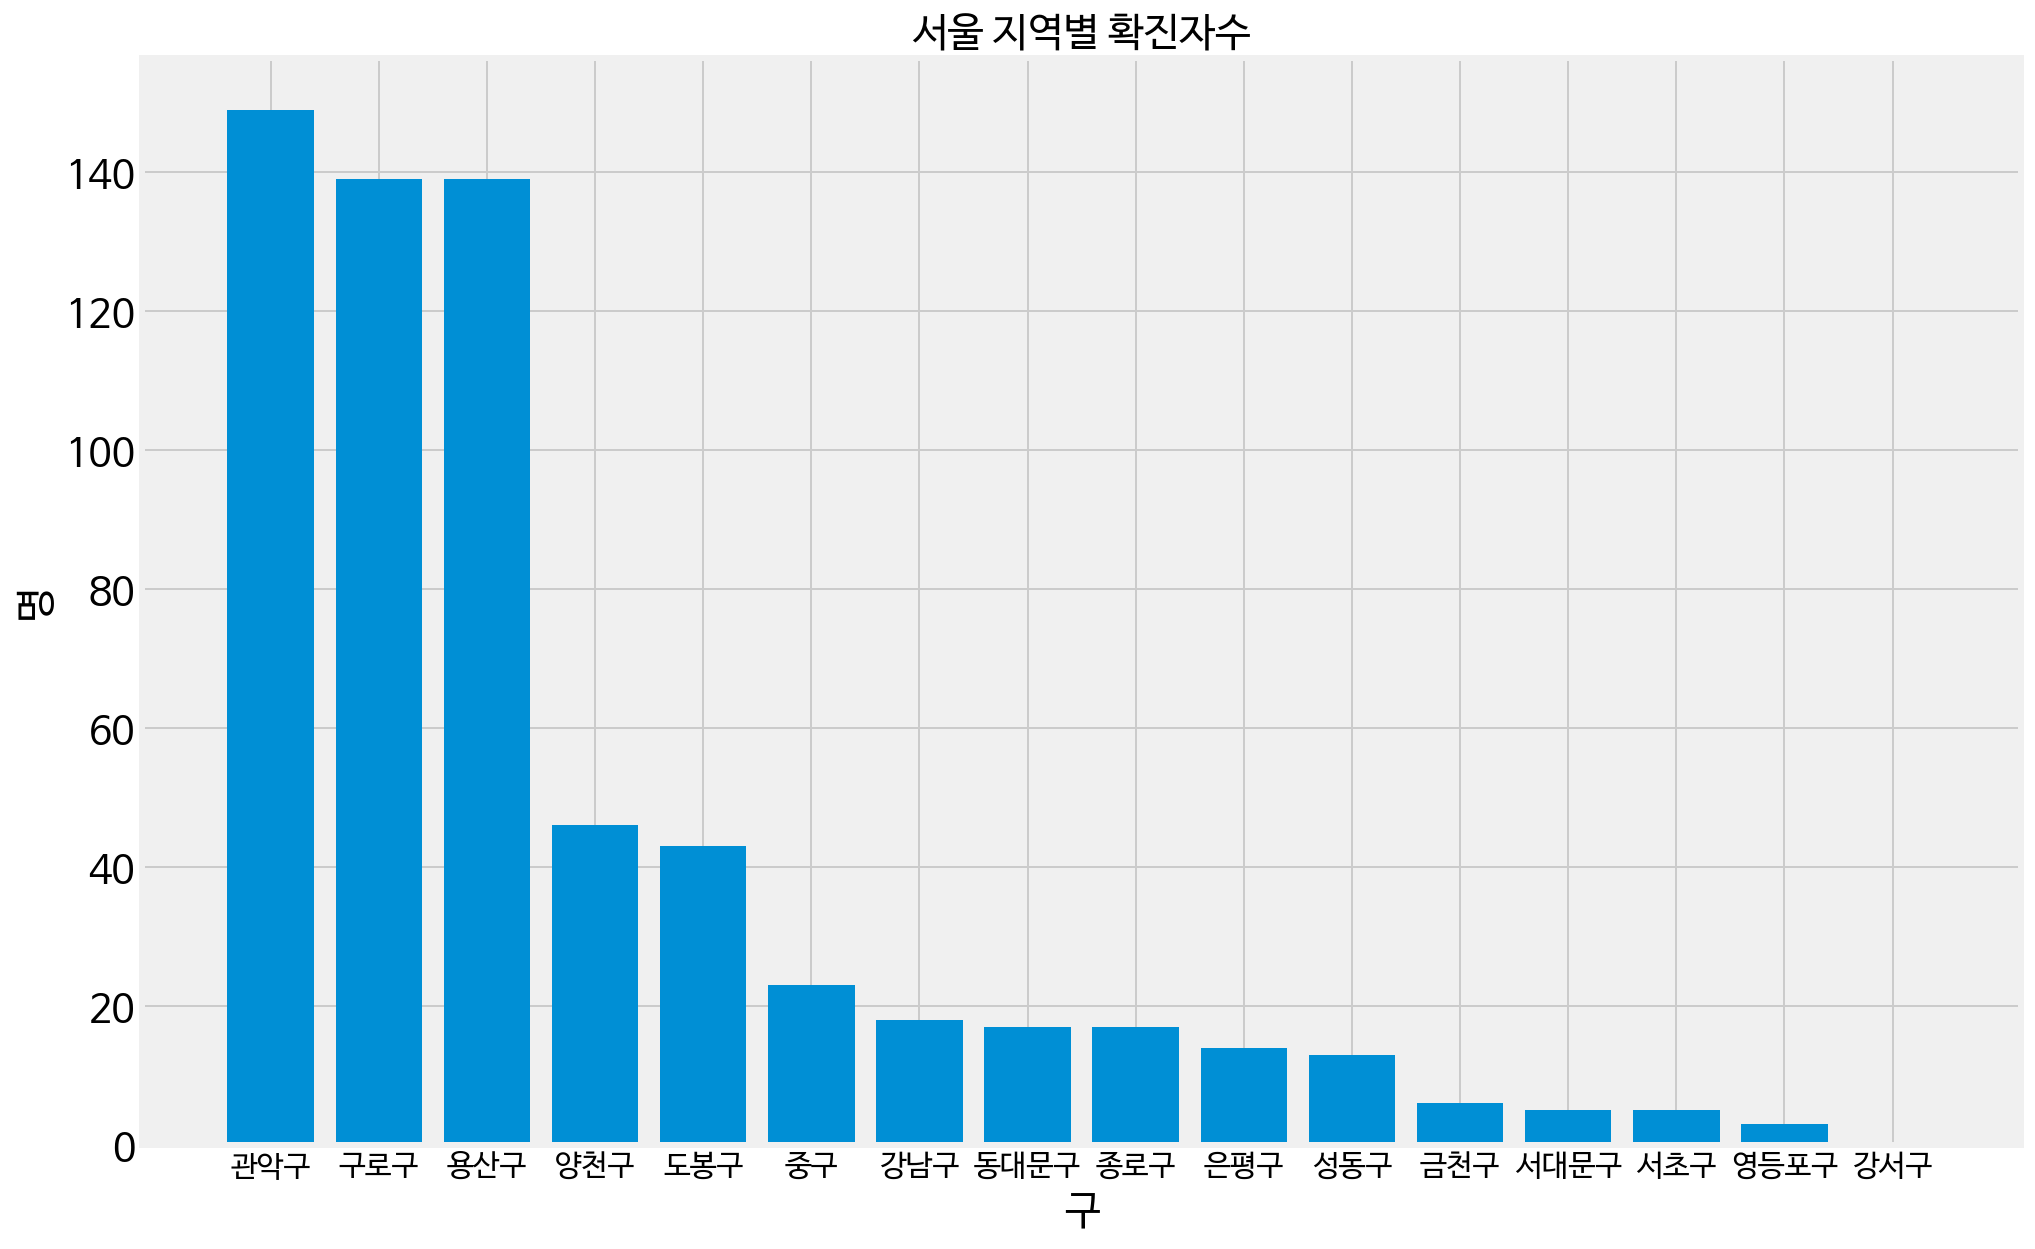

In [ ]:
plot_bar_x(covid_case_seoul_sorted,"city","confirmed","서울 지역별 확진자수")

집단감염발생 구역 분류

In [ ]:
#서울 내 집단감염발생 구역 분류
covid_case_seoul_mass=covid_case_seoul[covid_case_seoul["confirmed"]>4]
covid_patient_seoul=covid_patient[covid_patient.province=="서울"].drop(columns="province")
covid_patient_seoul["contact_number"]=covid_patient_seoul["contact_number"].fillna(0)
covid_patient_seoul.groupby(["infection_case","city"])["contact_number"].count().to_frame()

contact_number
infection_case                  city                
Anyang Gunpo Pastors Group      금천구                1
Biblical Language study meeting 송파구                2
                                양천구                1
Coupang Logistics Center        강서구               10
                                관악구                1
...                                              ...
overseas inflow                 용산구               16
                                은평구                8
                                종로구                6
                                중구                 3
                                중랑구                8

[250 rows x 1 columns]

In [ ]:
#감염케이스 데이터 전처리
covid_patient_infection_case=covid_patient.groupby("infection_case")["confirmed_date"].value_counts().to_frame()
covid_patient_infection_case_sorted=covid_patient_infection_case.groupby("infection_case")["confirmed_date"].sum().to_frame().sort_values(by=["confirmed_date"], ascending=False).reset_index()
covid_case_seoul_mass_for_compare=covid_case_seoul_mass[["infection_case","confirmed"]]
covid_patient_infection_case_compare=pd.merge(covid_patient_infection_case_sorted,covid_case_seoul_mass_for_compare, how="outer", on="infection_case")
covid_patient_infection_case_compare.columns=["infection_case","national","seoul"]
covid_patient_infection_case_compare.fillna(0, inplace=True)
covid_patient_infection_case_compare.drop(index=[0,1,2],inplace=True) #exclude non-specific cases


Text(0.5, 1.0, '서울 전국 집단감염 확진자 수')

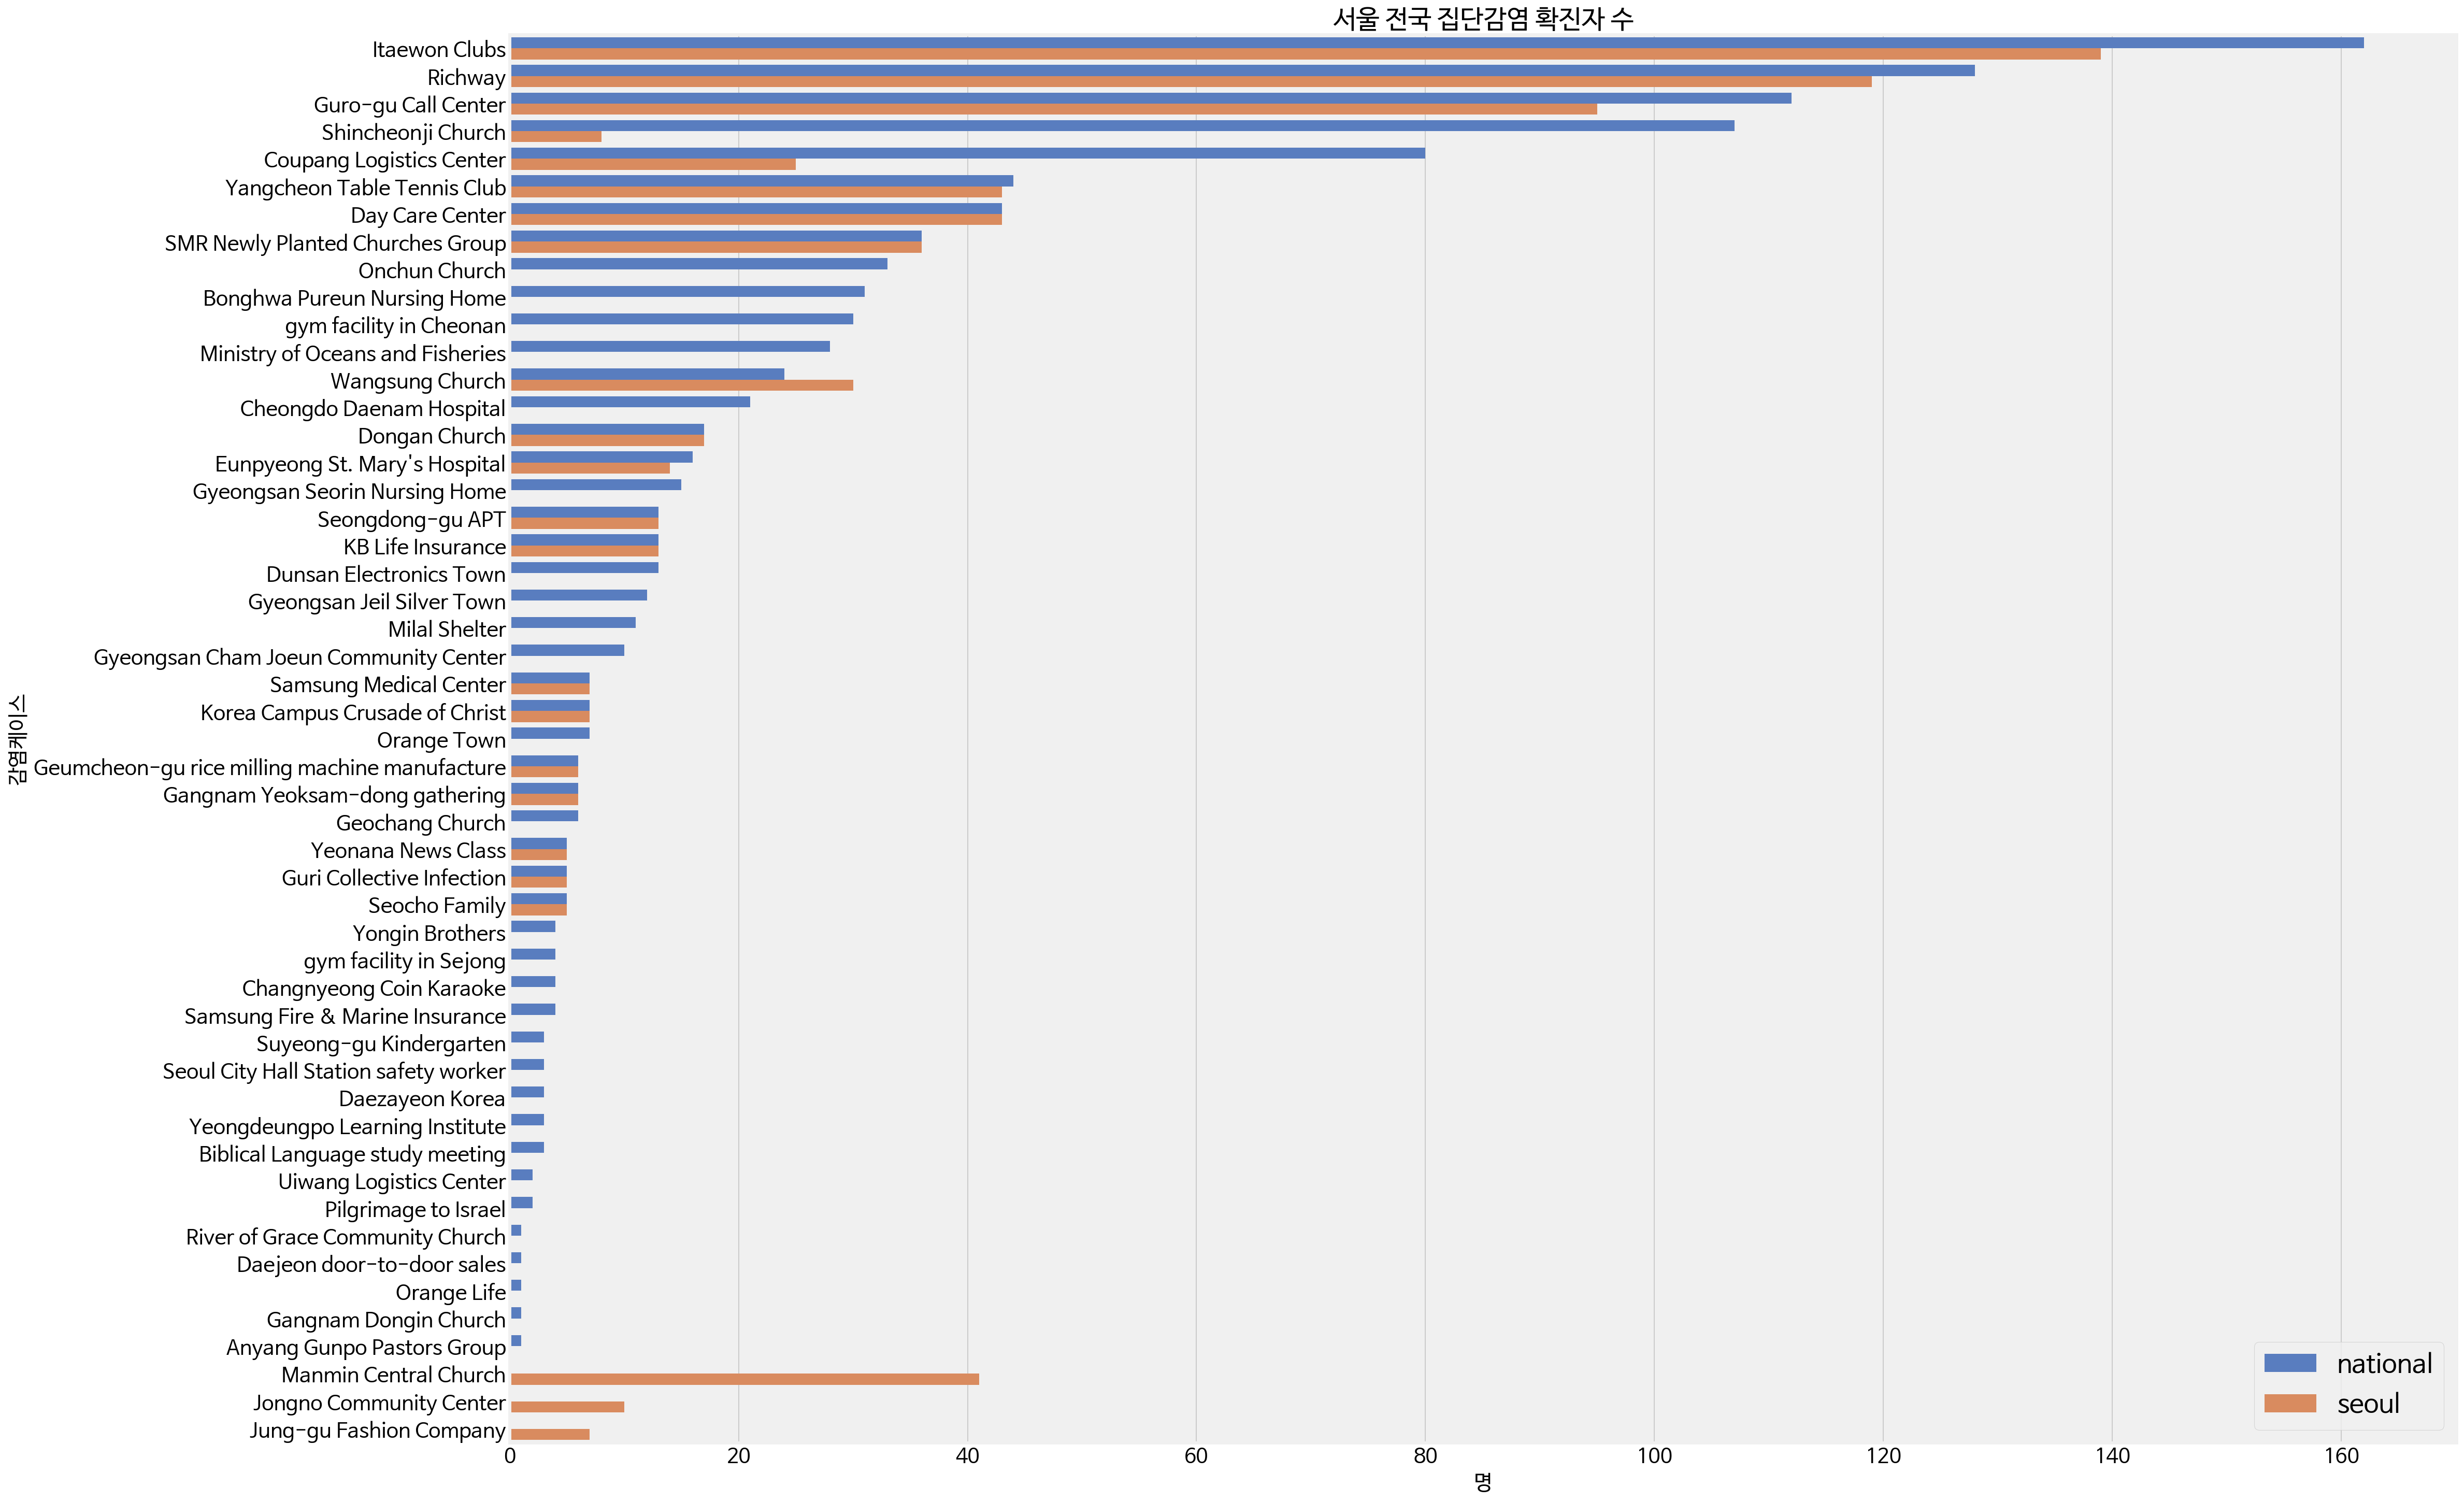

In [ ]:
#서울 전국 집단감염 케이스 비교 그래프
df2 = pd.melt(covid_patient_infection_case_compare, id_vars=['infection_case'], value_vars=['national','seoul'], var_name='number')
plt.rcParams["figure.figsize"] = (30,25)
fig,ax = plt.subplots()
sns.set_color_codes("pastel")
sns.barplot(x="value", y="infection_case", hue="number", data=df2, palette='muted')

for i,m in covid_patient_infection_case_compare.iterrows():
                xy=(m.loc[['national','seoul']].max(),i),
                xytext=(10,0),
                textcoords='offset pixels',
                fontsize=30,
                ha='left',
                va='center'

plt.legend(fontsize=25)
plt.rcParams["legend.loc"] = 'best'
plt.xlabel('명', fontsize=20)
plt.ylabel('감염케이스', fontsize=20)
plt.title("서울 전국 집단감염 확진자 수", fontsize=25)

전국의 감염케이스와 서울 내 집단감염 케이스의 확잔자의 수를 비교하였다. 서울의 집단감염이 전국적으로 비교했을 때 얼마나 많은 수를 차지하는 지 비교하기 위해 서울의 집단감염 케이스와 상관성이 적은 해외유입, 확진자 접촉 및 기타 케이스는 제외했다.

이태원클럽, 리치웨이, 구로구 콜센터 내 집단감염의 숫자가 전국의 감염케이스들의 확진자 숫자보다 크다. 

서울 내 집단감염 발생 날짜

In [ ]:
#집단감염 발생 케이스 날짜별로 분류
covid_case_seoul_mass_sorted=covid_case_seoul_mass[covid_case_seoul_mass.group==True].sort_values(by=["confirmed"], ascending=False)
covid_patient_seoul_mass_infection_date=covid_patient_seoul.groupby("infection_case")["confirmed_date"].value_counts().to_frame()
covid_patient_seoul_mass_infection_date

covid_patient_seoul_mass_infection_date_start={}
no_covid_patient_seoul_mass_infection_date_start_info=[]


for i in covid_case_seoul_mass_sorted["infection_case"]: 
  if i in covid_patient_seoul_mass_infection_date.index: #no patient info place
    covid_patient_seoul_mass_infection_date_start[i]=covid_patient_seoul_mass_infection_date.loc[i].iloc[0].name #감염 케이스 별 첫 확진 날짜
  else:
    no_covid_patient_seoul_mass_infection_date_start_info+=[i]

In [ ]:
#데이터 날짜 변환
covid_patient_seoul_mass_infection_date_start=pd.DataFrame.from_dict(covid_patient_seoul_mass_infection_date_start, orient='index', columns=['Date']) #확진날짜 데이터프레임 변환
covid_patient_seoul_mass_infection_date_start.reset_index(inplace=True)
covid_patient_seoul_mass_infection_date_start.columns=["infection_case","Date"]
covid_patient_seoul_mass_infection_date_start['Date'] = pd.to_datetime(covid_patient_seoul_mass_infection_date_start['Date'])
covid_case_seoul_mass_sorted_with_date=pd.merge(covid_case_seoul_mass_sorted,covid_patient_seoul_mass_infection_date_start, how="outer", on="infection_case")
covid_case_seoul_mass_sorted_with_date["Date"]=pd.to_datetime(covid_case_seoul_mass_sorted_with_date["Date"])
covid_case_seoul_mass_sorted_with_date.dropna(inplace=True)
covid_case_seoul_mass_sorted_with_date.sort_values(by="Date", inplace=True)
covid_case_seoul_mass_sorted_with_date["weekday"]=covid_case_seoul_mass_sorted_with_date["Date"].dt.weekofyear
covid_case_seoul_mass_sorted_with_date["weekday"].columns="주차"

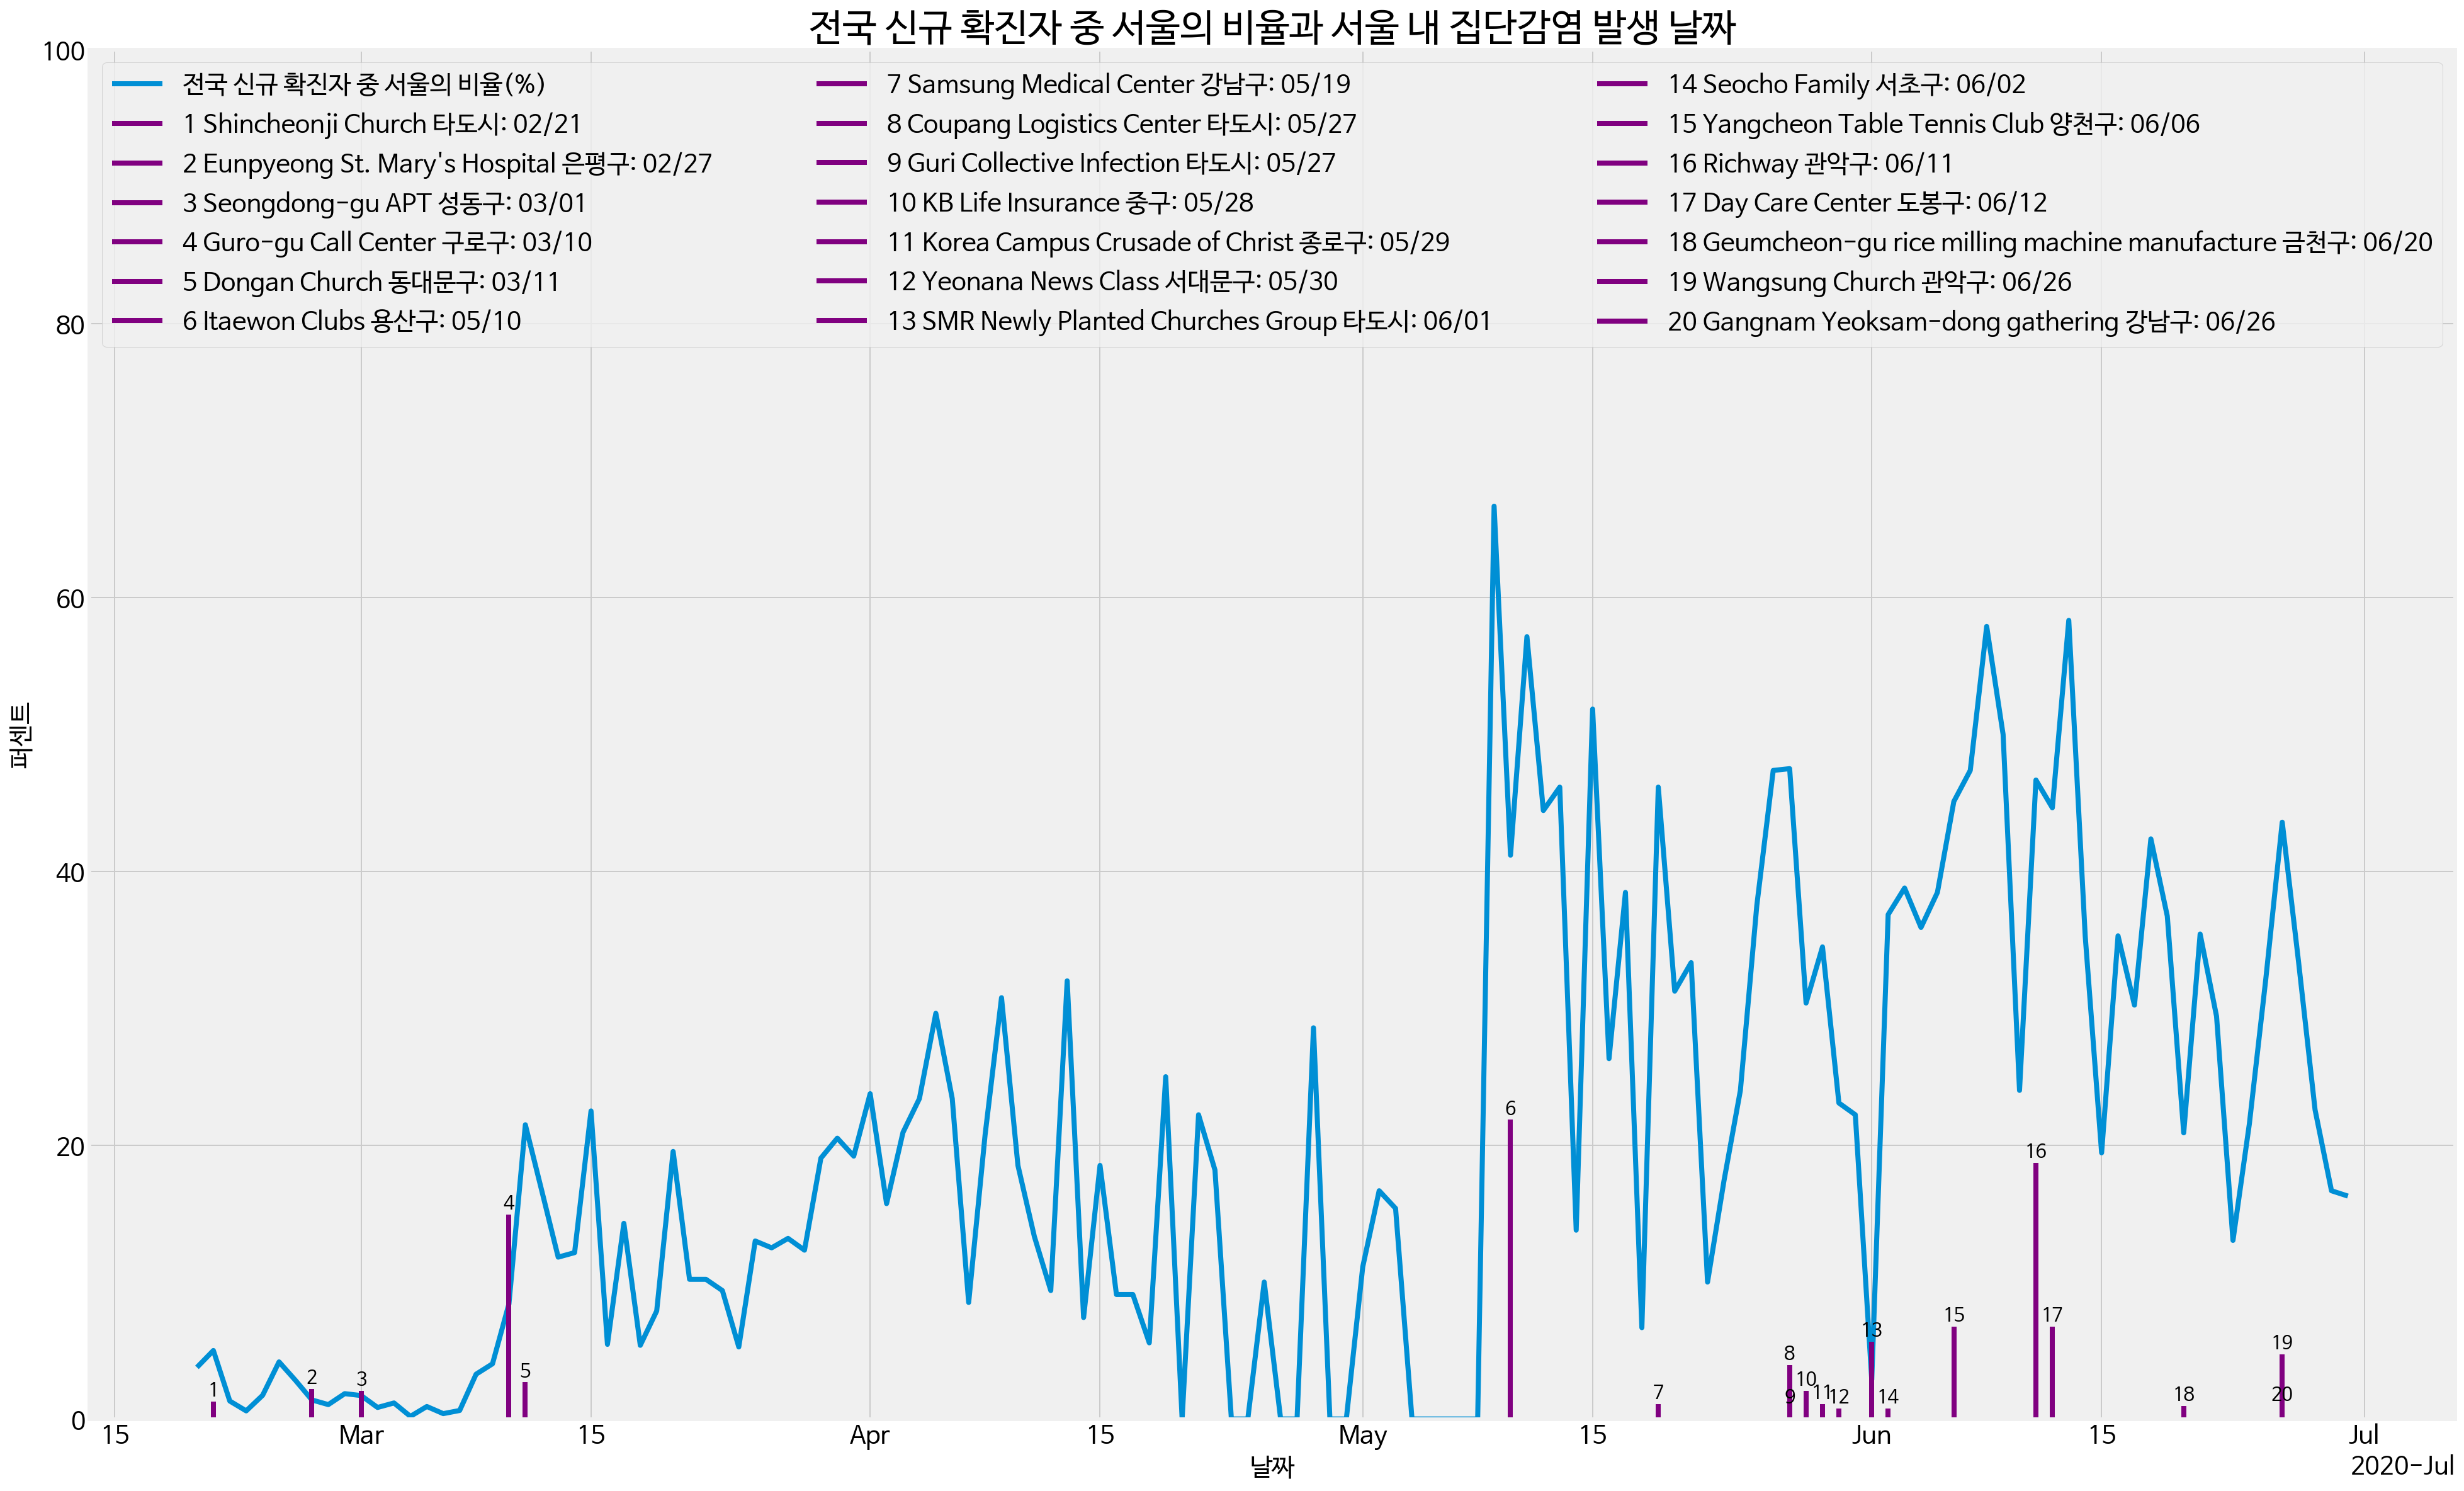

In [ ]:
#그래프 그리기
plt.rcParams["figure.figsize"] = (30,20)
ax = plt.gca()
x1=covid_df_compare_percent.loc["2020-02-20":,:].reset_index()
y1=covid_df_compare_percent.loc["2020-02-20":,:][["서울_비중(%)"]].reset_index()
locator = mdates.AutoDateLocator(minticks=12, maxticks=14)
formatter = mdates.ConciseDateFormatter(locator)
ax.xaxis.set_major_locator(locator)
ax.xaxis.set_major_formatter(formatter)
ax.set_ylim(0,100)

plt.plot(x1[["날짜"]], y1[["서울_비중(%)"]],label='전국 신규 확진자 중 서울의 비율(%)')
plt.setp([a.get_xticklabels() for a in fig.axes[:-1]], visible=True)
for i in range(len(covid_case_seoul_mass_sorted_with_date)):
  if covid_case_seoul_mass_sorted_with_date["Date"].iloc[i]!=0:
    plt.axvline(covid_case_seoul_mass_sorted_with_date["Date"].iloc[i],ymax=covid_case_seoul_mass_sorted_with_date["confirmed"].iloc[i]/covid_case_seoul_mass_sorted_with_date["confirmed"].sum(),color='purple', label=str(i+1)+" "+covid_case_seoul_mass_sorted_with_date["infection_case"].iloc[i]+" "+covid_case_seoul_mass_sorted_with_date["city"].iloc[i]+": "+covid_case_seoul_mass_sorted_with_date["Date"].iloc[i].strftime("%m/%d"))
    plt.text(covid_case_seoul_mass_sorted_with_date["Date"].iloc[i], covid_case_seoul_mass_sorted_with_date["confirmed"].iloc[i]/covid_case_seoul_mass_sorted_with_date["confirmed"].sum()*100, str(i+1), ha='center', va='bottom', fontsize=15)
plt.legend(loc="upper left", mode = "expand", ncol = 3, fontsize=20)
plt.title("전국 신규 확진자 중 서울의 비율과 서울 내 집단감염 발생 날짜", fontsize=30)
plt.xlabel('날짜', fontsize=20)
plt.ylabel('퍼센트', fontsize=20)
plt.show()


포스트 코로나 초기부터 중반까지는 서울의 신규확진자 비율은 전국의 30% 안쪽이었다. 하지만 5월 초부터 서울에서 집단감염 케이스가 증가하면서 신규확진자 비율은 전국의 50% 안팎로 증가했다.  

### 서울 집단감염 발생구역 지도 표시

In [ ]:
#지도 다운로드 및 데이터 전처리
covid_case_seoul_mass_sorted_with_date_folium=covid_case_seoul_mass_sorted_with_date.groupby(["city"])["confirmed"].sum().reset_index()
url = 'https://raw.github.com/PinkWink/DataScience/master/data/02.%20skorea_municipalities_geo_simple.json'
with urllib.request.urlopen(url) as fp:
  gu_geojson = json.loads(fp.read())
map_gu=covid_case_seoul_mass_sorted_with_date_folium
for idx, gu_dict in enumerate(gu_geojson['features']):
  if gu_dict["id"] in list(map_gu["city"]):
    gu_nm = gu_dict['id']
    value = map_gu.loc[map_gu.city==gu_nm, 'confirmed'].iloc[0]
    txt = f'{gu_nm}<br>{value}'
    gu_geojson['features'][idx]['properties']['tooltip1'] = txt
  else:
    gu_geojson['features'][idx]['properties']['tooltip1'] = f'{gu_dict["id"]}<br>0'

In [ ]:
#지도 데이터 표시
print('>>> 서울시 자치구별 코로나19 민감지수 지도')
m = folium.Map(location=[37.562225, 126.978555], zoom_start=11, tiles='Stamen Toner')
choropleth = folium.Choropleth(
    # name='choropleth',
    geo_data = gu_geojson,
    data = map_gu,
    columns = ['city', 'confirmed'],
    fill_color = 'Oranges',
    key_on = 'feature.id',
    fill_opacity=0.9,
    line_opacity=1,
    line_color="orange",
    legend_name="Number of Patients in Covid 19 Mass Infection"
).add_to(m)
choropleth.geojson.add_child(folium.features.GeoJsonTooltip(['tooltip1'], labels=False))
title_html = '<h3 align="center" style="font-size:20px"><b>Covid19 Mass Infection in Seoul</b></h3>'
m.get_root().html.add_child(folium.Element(title_html))
folium.LayerControl().add_to(m)
m

>>> 서울시 자치구별 코로나19 민감지수 지도


용산구, 관악구, 구로구에서 서울 내 집단감염으로 인한 확진자가 많이 발생했다.

강서구, 강동구, 강북구에서는 집단감염 및 감염자가 적거나 발생하지 않았다.
 